In [1]:
# ===========================
# Imports
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor

# ===========================
# Load Data
# ===========================
df = pd.read_csv("/workspaces/group-project-team-omega/code/cleanedData/Final_Model_data.csv")

# drop rows with missing target
df = df.dropna(subset=["first_pit_lap"])

# ===========================
# Feature + Target
# ===========================
final_features = [
    "year", "round", "circuitId",
    "driverId", "constructorId",
    "grid", "laps", "pit_stop_count",
    "track_length_km", "race_distance_km",
    "tyre_deg_level", "pit_lane_loss"
]

X = df[final_features]
y = df["first_pit_lap"]

In [2]:
# ===========================
# Categorical vs Numeric Split
# ===========================
cat_cols = ["circuitId", "driverId", "constructorId"]
num_cols = [col for col in final_features if col not in cat_cols]

# ===========================
# Preprocessor
# ===========================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# ===========================
# Extra Trees Model
# ===========================
et_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ExtraTreesRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

# ===========================
# Train-Test Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===========================
# Train
# ===========================
et_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [3]:
# ===========================
# Predict
# ===========================
train_pred = et_model.predict(X_train)
test_pred = et_model.predict(X_test)

# ===========================
# Metrics
# ===========================
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Train R2:", r2_score(y_train, train_pred))
print("Test R2:", r2_score(y_test, test_pred))


Train MAE: 4.0580172522566376e-14
Test MAE: 2.909478010853684
Train RMSE: 6.723152780977052e-14
Test RMSE: 5.141704281994753
Train R2: 1.0
Test R2: 0.5514935366656242


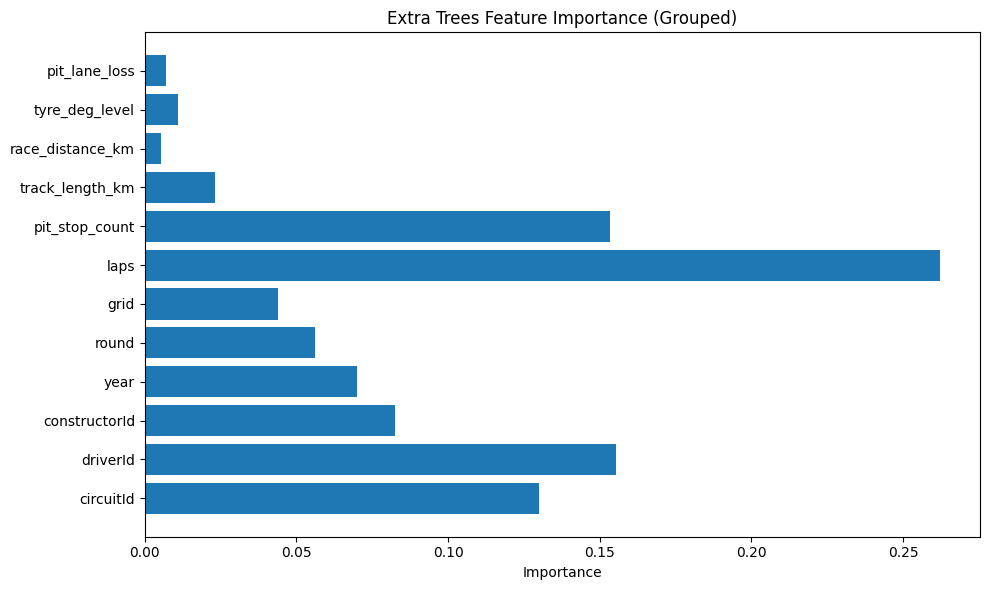

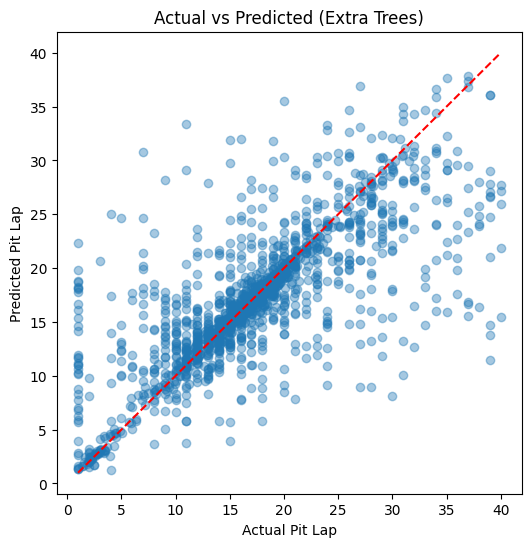

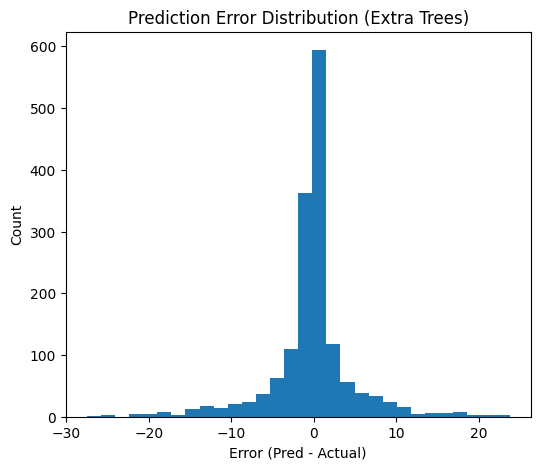

In [5]:
# ===========================
# VISUAL 1 — Feature Importance (Grouped)
# ===========================
et = et_model.named_steps["model"]

ohe = et_model.named_steps["preprocess"].named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)

all_feature_names = list(ohe_cols) + num_cols
raw_importances = et.feature_importances_

fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": raw_importances
})

# group back to original category features
grouped_importance = {
    "circuitId": fi_df[fi_df.feature.str.contains("circuitId")]["importance"].sum(),
    "driverId": fi_df[fi_df.feature.str.contains("driverId")]["importance"].sum(),
    "constructorId": fi_df[fi_df.feature.str.contains("constructorId")]["importance"].sum(),
}

# add numeric features normally
for col in num_cols:
    grouped_importance[col] = fi_df[fi_df.feature == col]["importance"].sum()

gi_df = pd.DataFrame(list(grouped_importance.items()), columns=["feature", "importance"])

plt.figure(figsize=(10, 6))
plt.barh(gi_df["feature"], gi_df["importance"])
plt.title("Extra Trees Feature Importance (Grouped)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ===========================
# VISUAL 2 — Actual vs Predicted
# ===========================
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred, alpha=0.4)
plt.xlabel("Actual Pit Lap")
plt.ylabel("Predicted Pit Lap")
plt.title("Actual vs Predicted (Extra Trees)")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.show()

# ===========================
# VISUAL 3 — Error Distribution
# ===========================
errors = test_pred - y_test

plt.figure(figsize=(6, 5))
plt.hist(errors, bins=30)
plt.title("Prediction Error Distribution (Extra Trees)")
plt.xlabel("Error (Pred - Actual)")
plt.ylabel("Count")
plt.show()